In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import numpy as np

In [2]:
def get_stock_price(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df_stock = stock.history(start=start_date, end=end_date).reset_index()
    
    date_list = df_stock['Date'].tolist()
    month_day_list = [date.strftime('%m-%d') for date in date_list]
    
    open_list = df_stock['Open'].tolist()
    close_list = df_stock['Close'].tolist()
    prices = []
    datestr = []
    for open, close, month in zip(open_list, close_list, month_day_list):
        prices.append(open)
        datestr.append(month + " O")
        prices.append(close)
        datestr.append(month + " C")
    return datestr, prices

## 获取情感分析结果与可靠性评估结果
切换PRED_PATH和EVAL_PATH以使用不同文件进行股价预测

In [3]:
PRED_PATH = "./data/tweets_epochs-8_rank-8_0.88.csv"
# PRED_PATH = "./data/RoBERTa_Large_tweets_pred.csv"
EVAL_PATH = "./output/llama2_tweets_0.88_eval.csv"
# EVAL_PATH = "./output/RoBERTa_Large_tweets_eval.csv"

# TSLA NFLX UNP AAPL HPQ CAT CRM NDAQ HPQ TGT
# LESS NEUTRAL: CAT CRM HPQ
# WORTH TO TALK: AAPL
# GOOD EXAMPLE: TSLA CVX NSC
symbol = 'NSC'
df_tweets = pd.read_csv(PRED_PATH)
df_select = df_tweets[df_tweets['symbols'] == symbol]

# date_list = pd.to_datetime(df_select["timestamp"]).dt.date
# date_list = [date.strftime('%m-%d') for date in date_list]
# df_select['date'] = date_list
df_select

,id,text,timestamp,source,symbols,company_names,url,verified,pred_sen
26,1.630000e+18,Are air and drinking water in the Ohio River b...,Sun Feb 26 21:28:04 +0000 2023,MarketWatch,NSC,Norfolk Southern,https://twitter.com/i/web/status/1629956487346...,NaN,2
32,1.630000e+18,Norfolk Southern this week can resume shipment...,Sun Feb 26 23:17:17 +0000 2023,business,NSC,Norfolk Southern,https://twitter.com/i/web/status/1629983973412...,NaN,2
378,1.630000e+18,After Ohio derailment Norfolk Southern announc...,Mon Mar 06 12:32:27 +0000 2023,MarketWatch,NSC,Norfolk Southern,https://trib.al/xDdJdO3true,NaN,2
379,1.630000e+18,Norfolk Southern announces six-point safety pl...,Mon Mar 06 12:41:28 +0000 2023,MarketWatch,NSC,Norfolk Southern,https://trib.al/JDTNLGrtrue,NaN,2
386,1.630000e+18,Norfolk Southern said it plans to add about 20...,Mon Mar 06 14:18:43 +0000 2023,WSJ,NSC,Norfolk Southern,https://twitter.com/i/web/status/1632747542600...,NaN,2
398,1.630000e+18,‰Û¢ Congress set to question Norfolk Southern ...,Mon Mar 06 15:46:22 +0000 2023,YahooFinance,NSC,Norfolk Southern,https://twitter.com/i/web/status/1632769598939...,NaN,2
418,1.630000e+18,Norfolk Southern said it will immediately begi...,Mon Mar 06 18:13:26 +0000 2023,MarketWatch,NSC,Norfolk Southern,https://twitter.com/i/web/status/1632806610077...,NaN,2
420,1.630000e+18,TikTok ban Norfolk Southern CEO testifies Soci...,Mon Mar 06 18:59:04 +0000 2023,YahooFinance,NSC,Norfolk Southern,https://yhoo.it/3Jhs7aFtrue,NaN,2
453,1.630000e+18,Though no hazardous materials leaked a Norfolk...,Tue Mar 07 00:05:04 +0000 2023,nytimes,NSC,Norfolk Southern,https://twitter.com/i/web/status/1632895102497...,NaN,2
457,1.630000e+18,Norfolk Southern announces safety upgrades fol...,Tue Mar 07 01:04:34 +0000 2023,MarketWatch,NSC,Norfolk Southern,https://trib.al/bHfaMErtrue,NaN,2


# 获取原始股价
利用原始股价与预测股价进行对比

In [4]:
start_date = pd.to_datetime(df_select.iloc[0]['timestamp']).date() + timedelta(days=1)
end_date = pd.to_datetime(df_select.iloc[-1]['timestamp']).date() + timedelta(days=5)
# 时间标签 开盘价 - 收盘价
datestr, prices = get_stock_price(symbol, start_date, end_date)

# 利用开盘价，推文作者准确度，以及预测情感，来预测收盘价

In [5]:
df_eval = pd.read_csv(EVAL_PATH)
df_eval

,author,time_window,acc_trend,roc_trend,acc_price,roc_price,p_0_trend,p_1_trend,p_2_trend,p_0_price,p_1_price,p_2_price
0,Reuters,1,0.200000,0.396923,0.371429,0.536923,0.750000,0.200000,0.122807,0.625000,0.200000,0.350877
1,business,1,0.170213,0.506410,0.297872,0.506410,0.400000,0.250000,0.117647,0.400000,0.125000,0.323529
2,MarketWatch,1,0.346939,0.593750,0.346939,0.500919,0.928571,0.235294,0.000000,0.714286,0.117647,0.277778
3,YahooFinance,1,0.142857,0.368421,0.214286,0.356725,0.500000,0.111111,0.066667,0.500000,0.000000,0.266667
4,Forbes,1,0.080000,0.439394,0.280000,0.287879,0.000000,0.333333,0.052632,0.000000,0.333333,0.315789
5,WSJ,1,0.153846,NaN,0.346154,NaN,1.000000,0.000000,0.000000,0.750000,0.000000,0.272727
6,TheStreet,1,0.111111,0.294118,0.222222,0.235294,0.000000,0.000000,0.125000,0.000000,0.000000,0.250000
7,GerberKawasaki,1,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,TechCrunch,1,0.105263,NaN,0.368421,NaN,1.000000,0.000000,0.055556,1.000000,0.000000,0.333333
9,nytimes,1,0.181818,NaN,0.545455,NaN,0.000000,0.000000,0.181818,0.000000,0.000000,0.545455


In [6]:
pred_prices = prices

pred_prices = [pred_prices[i - 1] if i % 2 != 0 else pred_prices[i] for i in range(len(pred_prices))]

# 根据 开盘价 情感 以及可靠性 进行加权累加
def cal_close_price(acc_price, sense, open_price):
    sense_num = random.uniform(-(open_price * 0.01), (open_price * 0.01))
    if sense == 0:
        sense_num = - (open_price * 0.03)
    elif sense == 1:
        sense_num = (open_price * 0.03)
    close_price = (1 / (1 + math.exp(5 - 10 * acc_price))) * sense_num
    
    return float(close_price)
     
        
for i in range(0, len(df_select)):
    # 遍历df_select
    date = pd.to_datetime(df_select.iloc[i]['timestamp']).date()
    author = df_select.iloc[i]['source']
    sense = df_select.iloc[i]['pred_sen']
    # print("author: ", author)
    # print("sense: ", sense)
    if author in df_eval["author"].tolist():
        for window in range(1, 6):
            cal_date = date + timedelta(days=window)
            time_str = cal_date.strftime('%m-%d') + " C"
    
            if time_str in datestr:
                index = datestr.index(time_str)
                
                author_eval = df_eval[df_eval['author'] == author]
                author_windows_eval = author_eval[author_eval['time_window'] == window]
                # author在window下的置信度
                acc_price = float(author_windows_eval.iloc[0]['acc_price'])
                # acc_price = "{:.3f}".format(float(author_eval['acc_price']))
                
                pred_prices[index] = pred_prices[index] + cal_close_price(acc_price, sense, pred_prices[index])
pred_prices  

[220.9729864371435,
 220.98232565069267,
 217.47426670154965,
 217.46624394470032,
 217.25133962506442,
 217.30557338762003,
 216.78612964191717,
 216.7083817956615,
 222.10694175676855,
 222.0038366856816,
 220.62410734041615,
 220.62410734041615,
 214.43103969171545,
 214.02276598290774,
 208.305807173883,
 207.05950494054943,
 210.09878853827402,
 210.27682676368207,
 206.78419916505206,
 204.48092315667313,
 202.18059649636754,
 200.9021442344781,
 204.4872478719493,
 203.86412170417472]

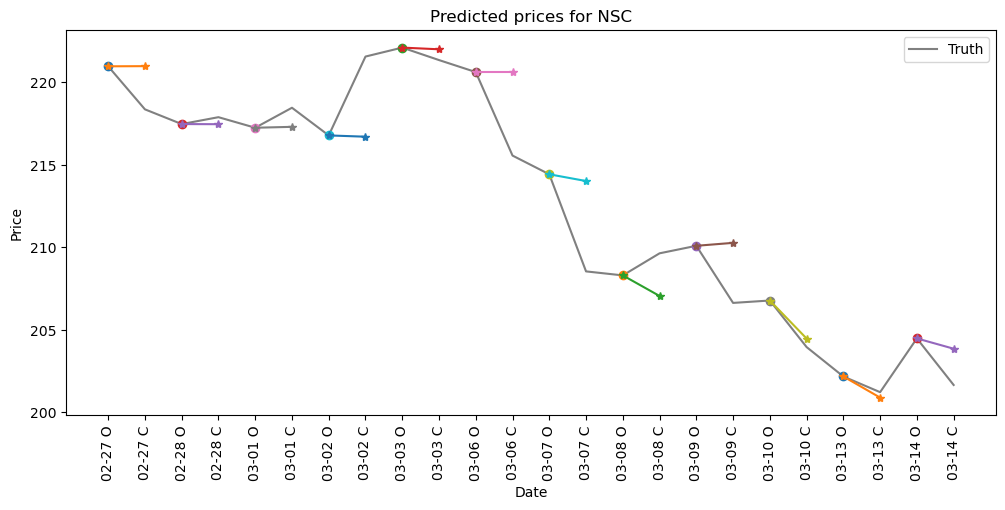

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(datestr, prices, label='Truth', color='grey')
# plt.plot(datestr,pred_prices, label='Prediction')
# 绘制真实价格，使用不同的符号
for i in range(len(datestr)):
    if i % 2 == 1:
        plt.plot(datestr[i-1:i+1], pred_prices[i-1:i+1]
                 , marker='*' if i % 2 == 1 else '')
    plt.plot(datestr[i], prices[i], marker='o' if i % 2 == 0 else '')
    
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title(f"Predicted prices for {symbol}")
plt.show()  

## 误差分析

Mean Squared Error: 9.420916440742584
Mean Absolute Error: 2.4587969886692655


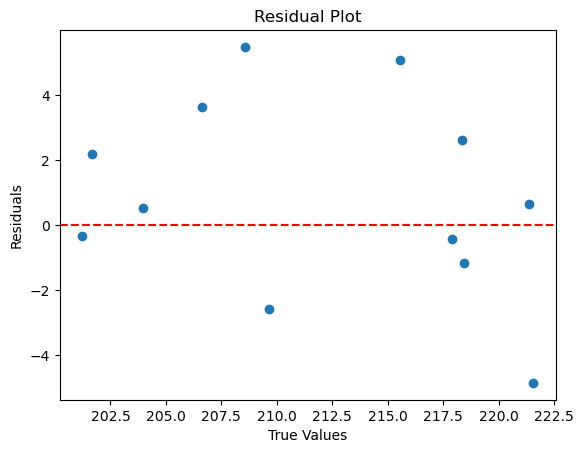

In [8]:
y_true = [prices[i] for i in range(len(prices)) if i % 2 != 0]
y_pred = [pred_prices[i] for i in range(len(pred_prices)) if i % 2 != 0]
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# 计算误差
errors = y_pred - y_true

# 计算MSE和MAE
mse = np.mean(errors**2)
mae = np.mean(np.abs(errors))

# 打印结果
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# 绘制残差图
plt.scatter(y_true, errors)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()